## Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf
import folium
import statsmodels.api as sm
from pylab import rcParams
import numpy as np

In [8]:
def create_catplot(data, x, y, col):
    """
    Input: data --> DataFrame
           x --> String 
           y --> String
           col --> String
    Output: FacetGrid (bar plots)
    
    # Takes a DataFrame, the columns that will map the x values and y values and 
    # a column that will determine the faceting of the grid.
    """
    
    return sns.catplot(x=x, y=y, col=col, data=data, col_wrap=4, kind='bar', sharey=False)

In [ ]:
def set_xticklabels(plt):
    """
    Input: FacetGrid
    
    # Takes a FacetGrid and 
    """

## Importing dataset

In [9]:
chicago_cmr1 = pd.read_csv('chicago_clean.csv')

In [31]:
chicago_cmr = pd.read_csv('../Data/Crimes_-_2001_to_present.csv')

In [10]:
data = chicago_cmr1.groupby(['District', 'Primary Type']).size().reset_index(name='Crime_Counts').groupby('District').apply(lambda x: x.sort_values(by='Crime_Counts', ascending=False).head(5))
print(data)

              District        Primary Type  Crime_Counts
District                                                
1.0      30        1.0               THEFT        115819
         2         1.0             BATTERY         26177
         8         1.0  DECEPTIVE PRACTICE         24415
         7         1.0   CRIMINAL TRESPASS         20198
         6         1.0     CRIMINAL DAMAGE         14217
2.0      34        2.0             BATTERY         64778
         63        2.0               THEFT         62623
         49        2.0           NARCOTICS         33634
         38        2.0     CRIMINAL DAMAGE         32155
         33        2.0             ASSAULT         21938
3.0      67        3.0             BATTERY         75662
         96        3.0               THEFT         50155
         71        3.0     CRIMINAL DAMAGE         39470
         82        3.0           NARCOTICS         33325
         66        3.0             ASSAULT         24964
4.0      100       4.0         

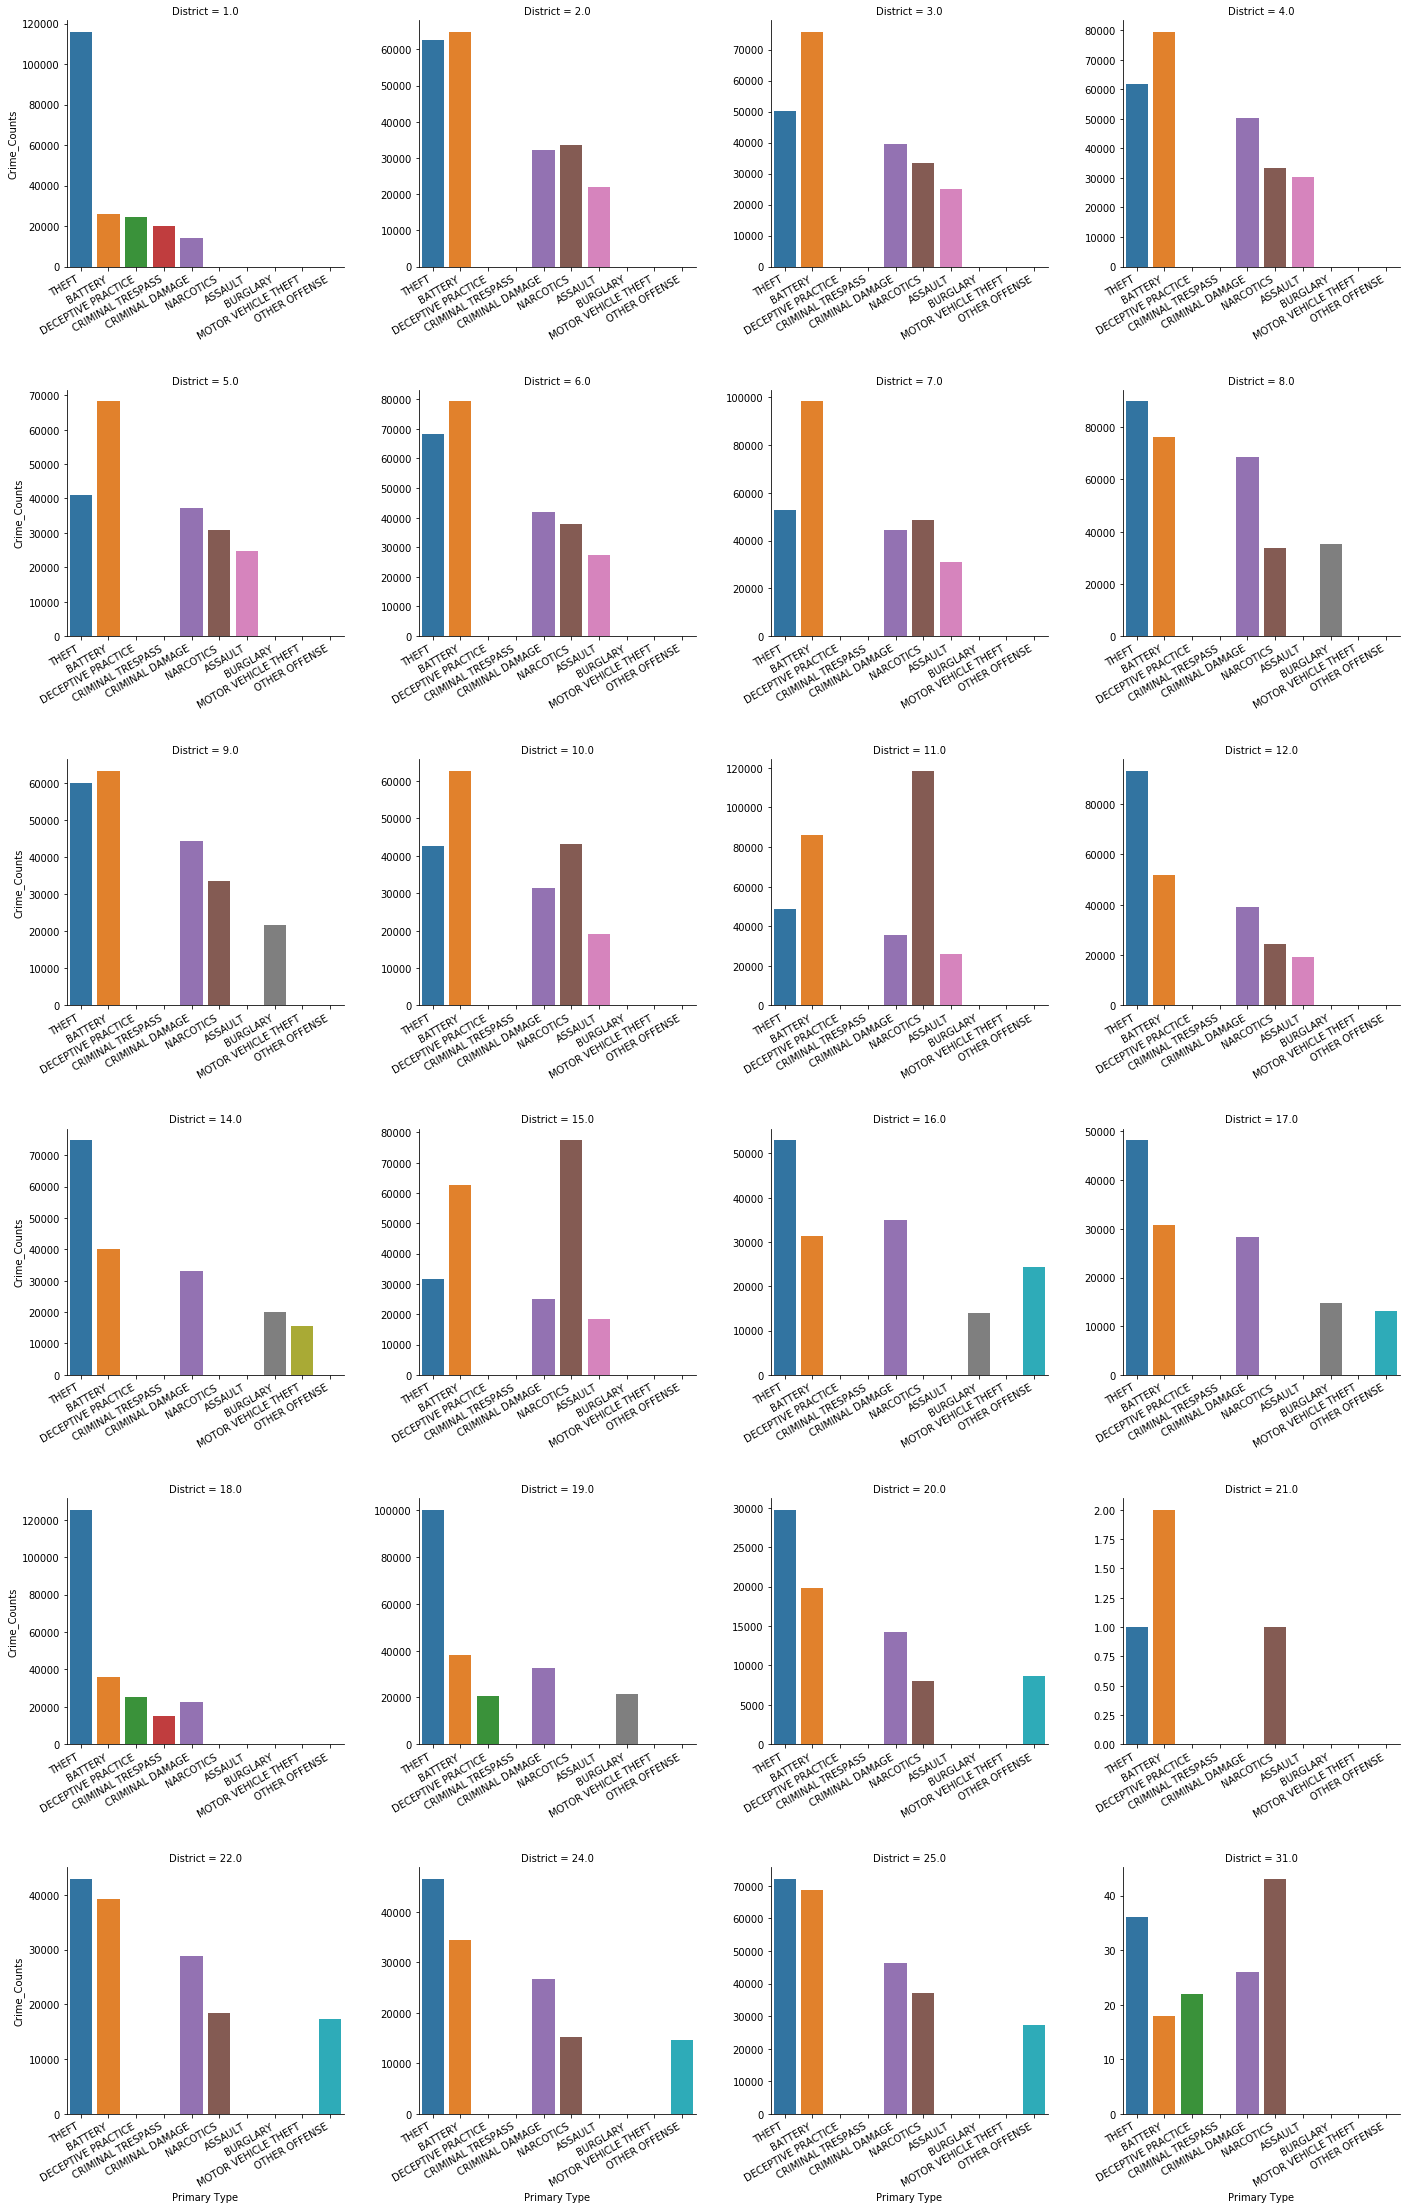

In [11]:
# Plotting top 5 crime types commited per District
crimeT_district =create_catplot(data, 'Primary Type', 'Crime_Counts', 'District')
for ax in crimeT_district.axes:
    # setp --> Receives an object of the plot and can change its properties.
    # setting x labels properties
    # ha --> horizontal alignment
    plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')

# Setting space between subplots
plt.subplots_adjust(hspace=0.5)


In [12]:
type(crimeT_district)

seaborn.axisgrid.FacetGrid

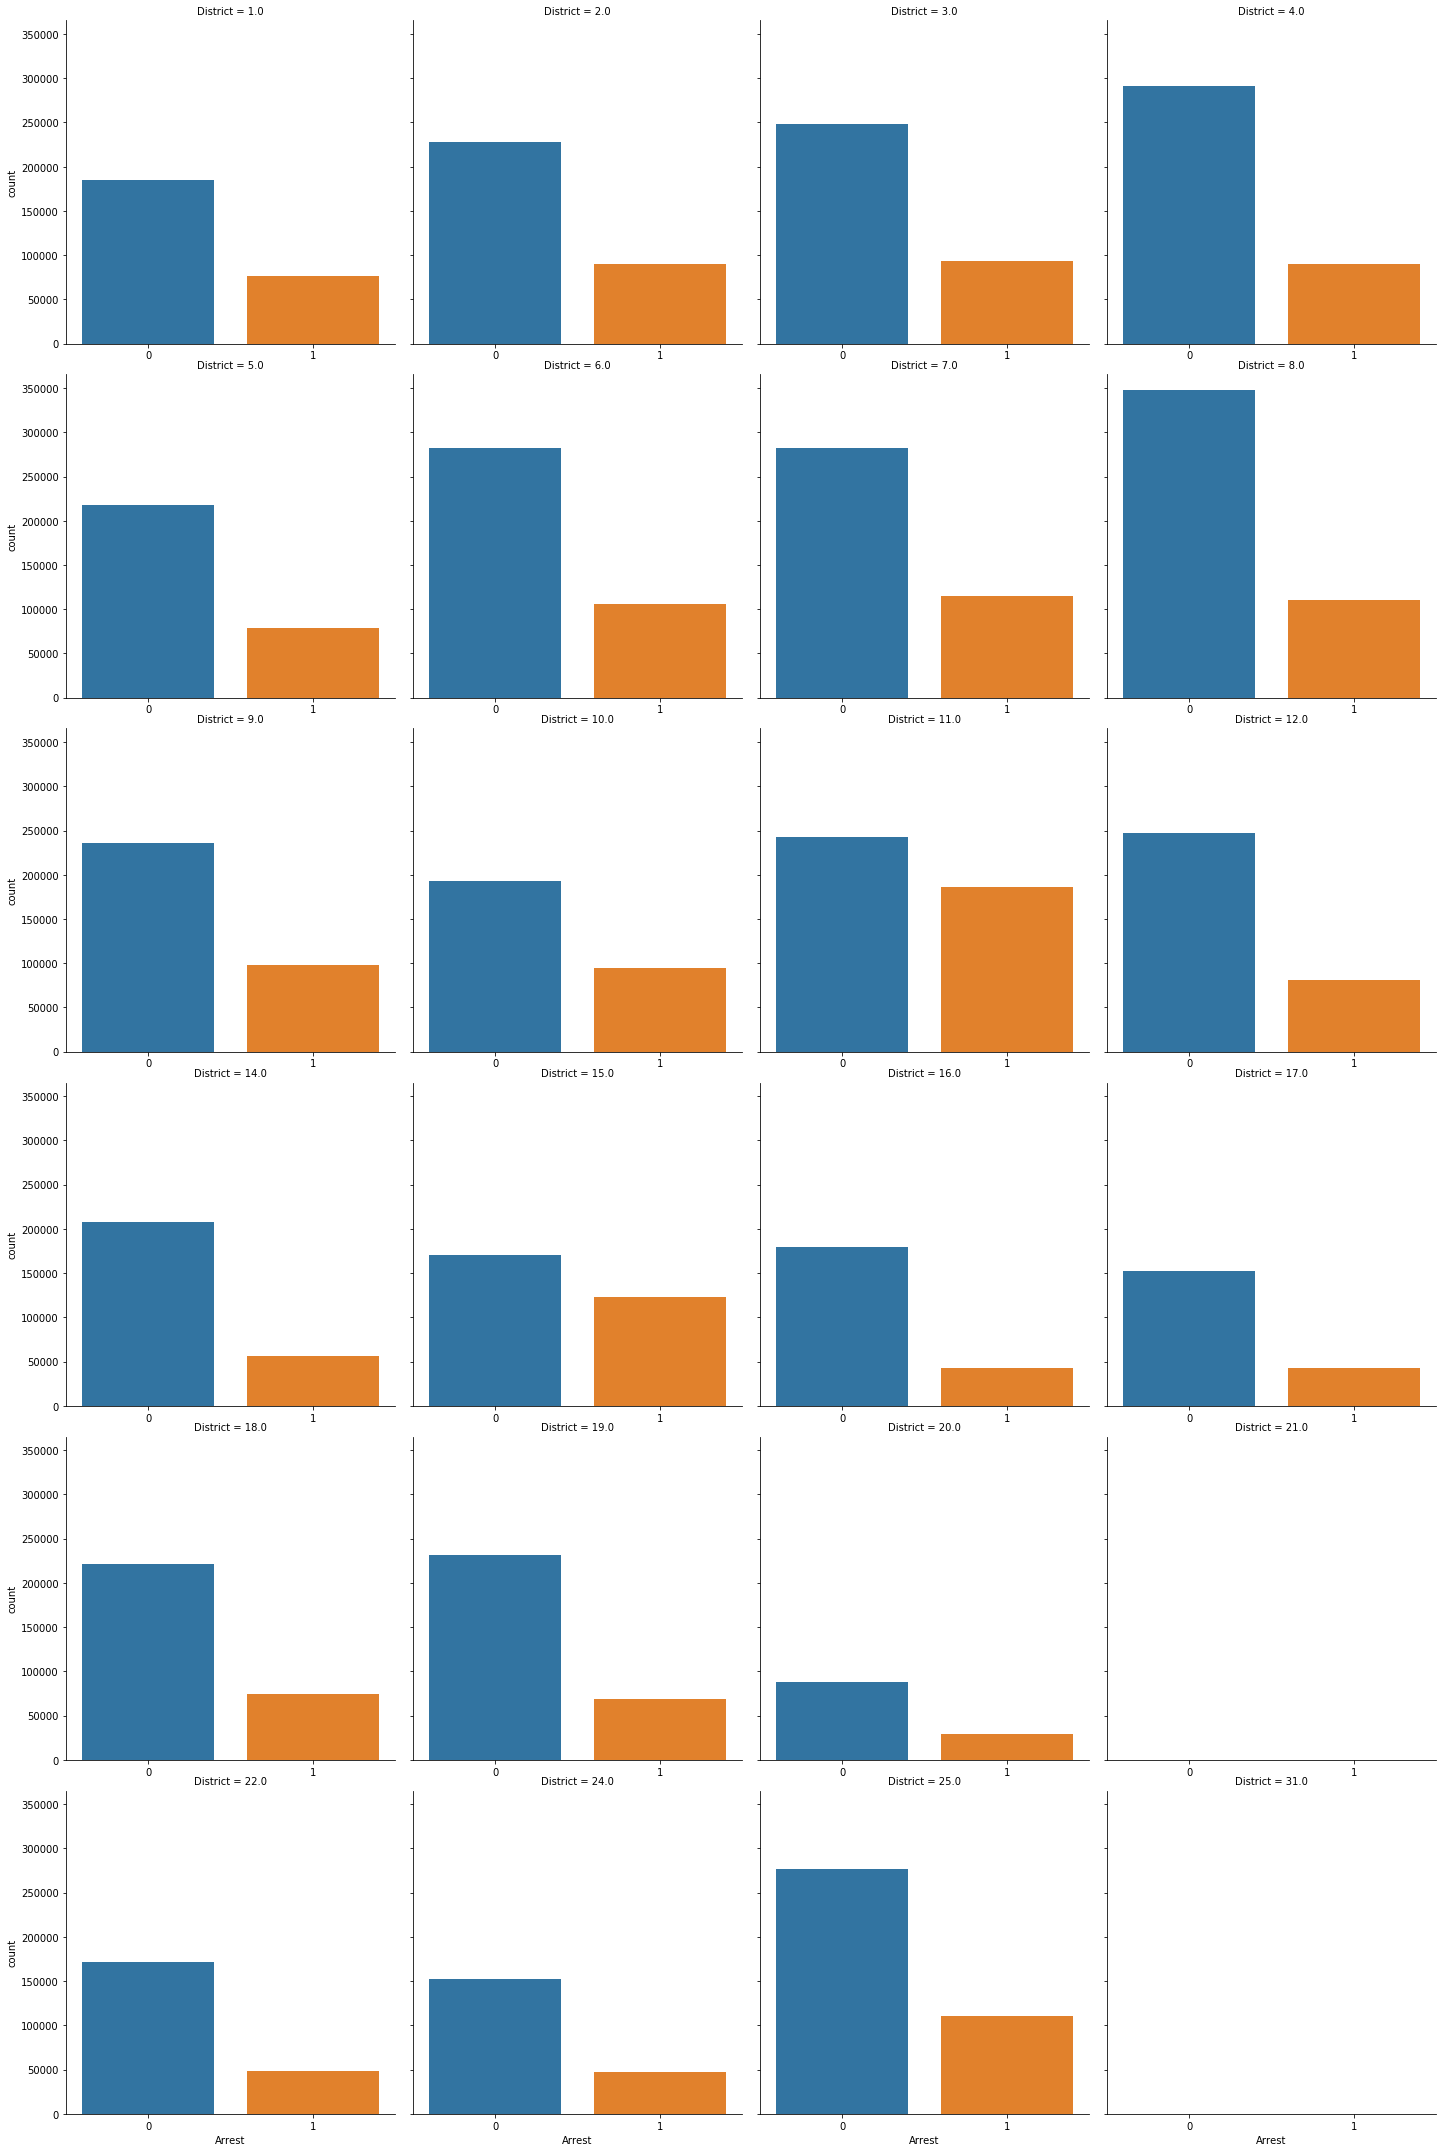

In [7]:
arrest_district =sns.catplot("Arrest", col="District", col_wrap=4, data=chicago_cmr1, kind="count")

for ax in arrest_district.axes:
    plt.setp(ax.get_xticklabels(), visible=True)

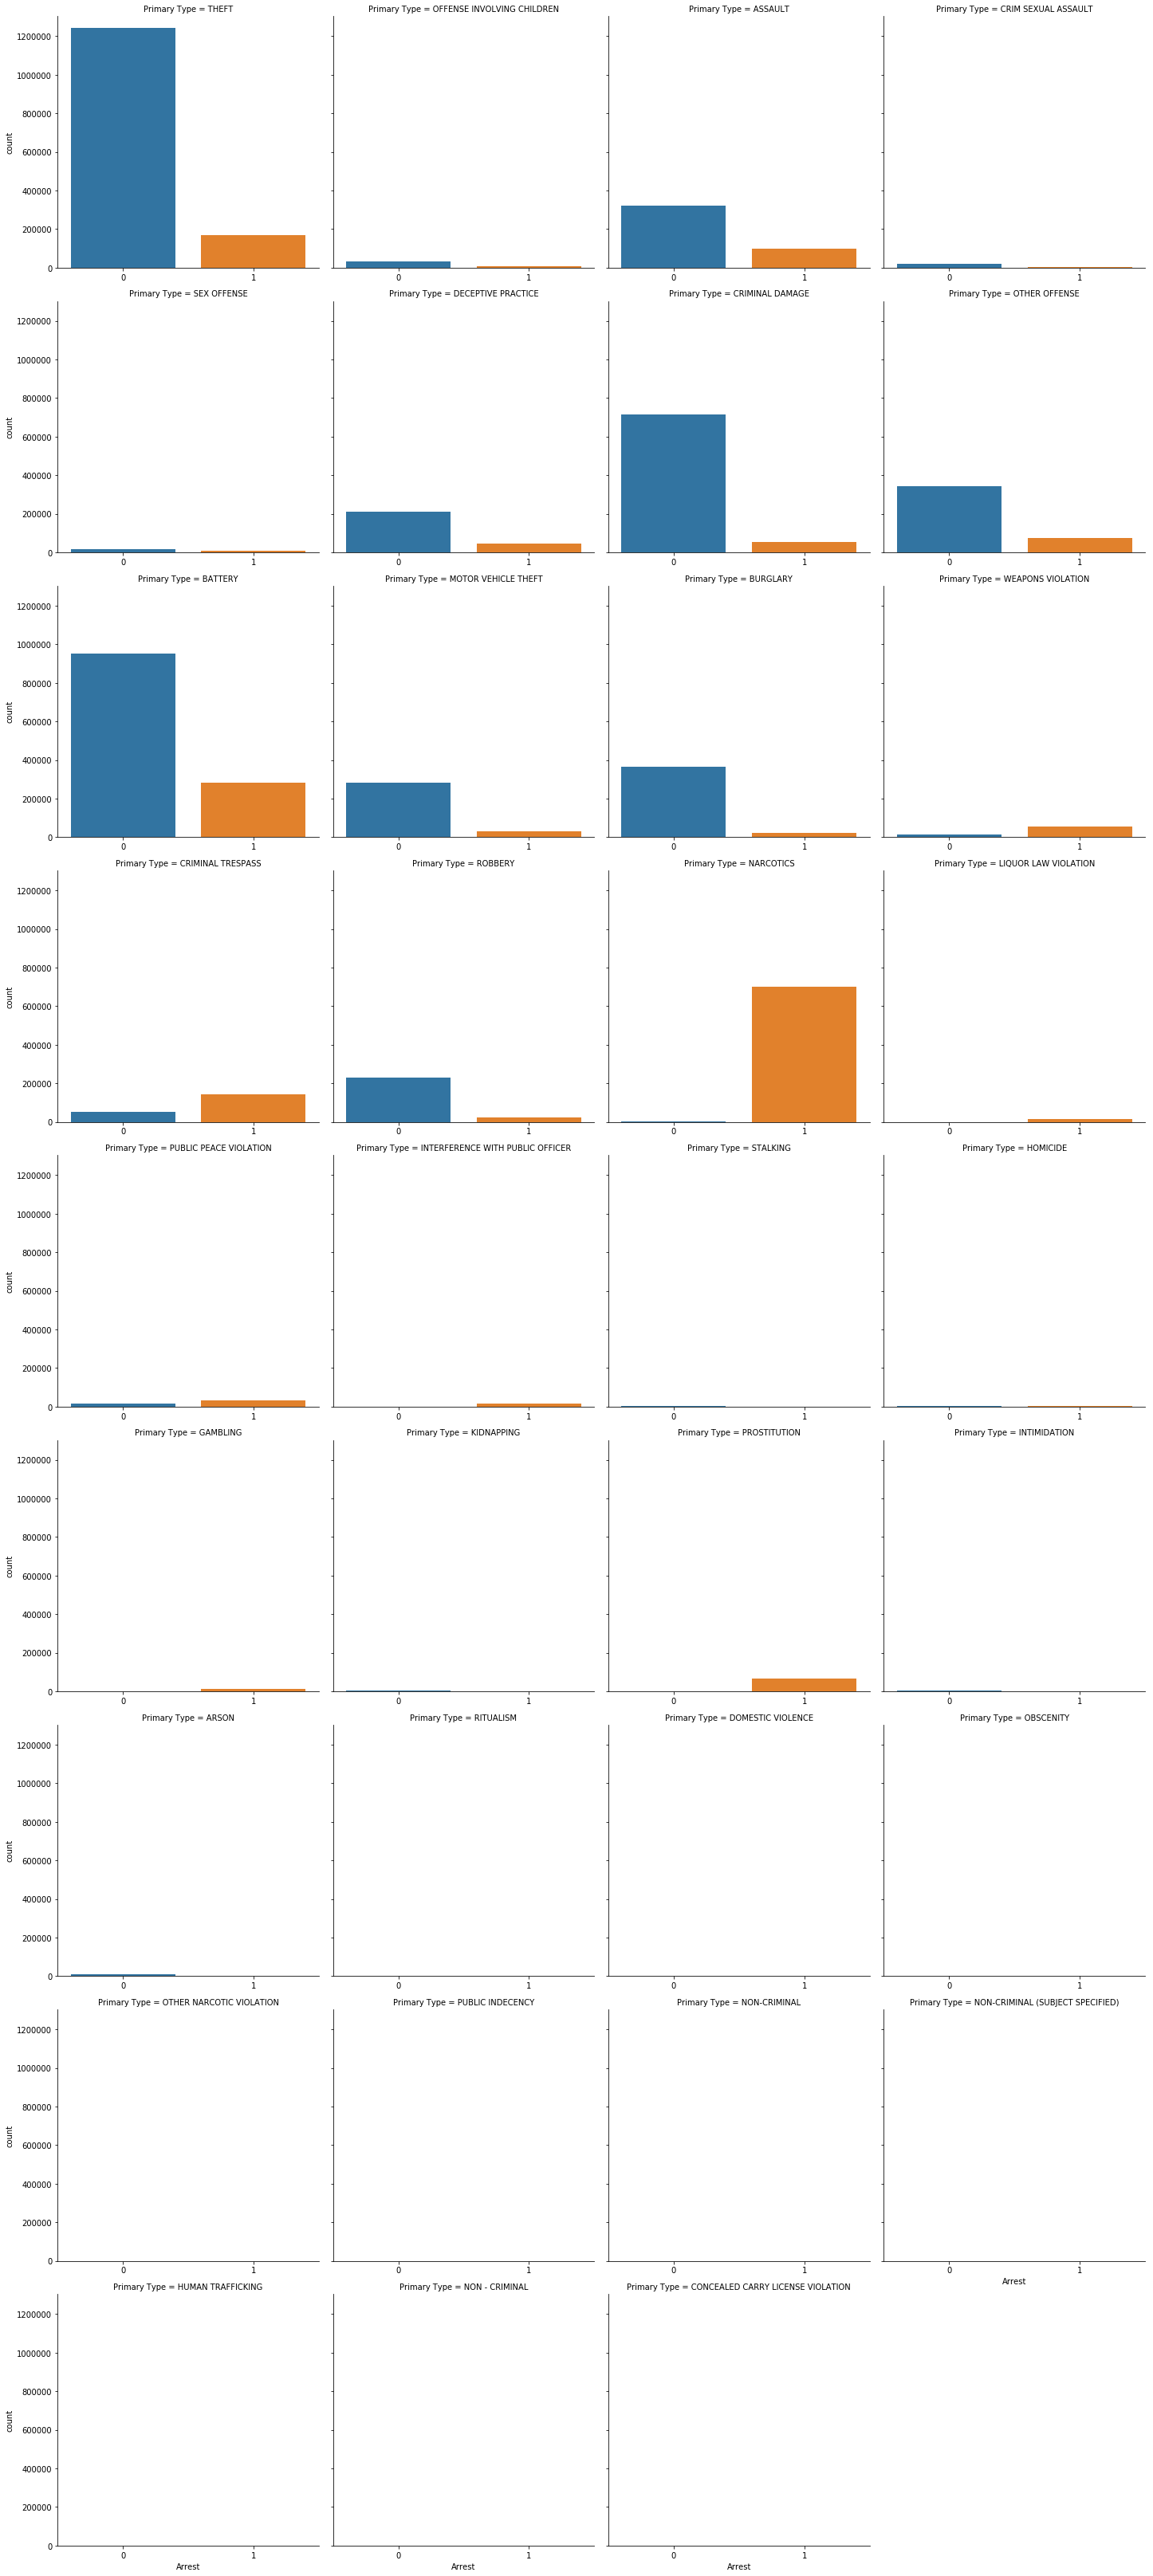

In [83]:
arrest_primaryT =sns.catplot("Arrest", col="Primary Type", col_wrap=4, data=chicago_cmr1, kind="count")

for ax in arrest_primaryT.axes:
    plt.setp(ax.get_xticklabels(), visible=True)

In [87]:
chicago_cmr1.index = pd.DatetimeIndex(chicago_cmr1['Date'])

,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Year,Latitude,Longitude,Location
Date,,,,,,,,,,,,,
2001-01-01 00:00:00,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,631,6.0,2001,41.748623,-87.608654,"(41.748623027, -87.608654109)"
2001-01-01 00:00:00,2001-01-01 00:00:00,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,0,0,624,6.0,2001,41.754802,-87.598147,"(41.754802305, -87.598146873)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0810,THEFT,OVER $500,APARTMENT,0,0,2332,19.0,2001,41.938952,-87.638164,"(41.938952432, -87.638163582)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,624,6.0,2001,41.752062,-87.607828,"(41.752061911, -87.607827503)"
2001-01-01 00:00:00,2001-01-01 00:00:00,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,0,0,1013,10.0,2001,41.850386,-87.715108,"(41.850385805, -87.715107802)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0810,THEFT,OVER $500,PARKING LOT/GARAGE(NON.RESID.),0,0,122,1.0,2001,41.886704,-87.628054,"(41.886703808, -87.628054456)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,0,0,823,8.0,2001,41.780623,-87.707393,"(41.780622885, -87.707393268)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,1021,10.0,2001,41.862175,-87.711496,"(41.862174853, -87.711495725)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0560,ASSAULT,SIMPLE,APARTMENT,0,1,2433,24.0,2001,41.994699,-87.657187,"(41.994699275, -87.657186625)"


In [101]:
crimes_per_district = chicago_cmr1.pivot_table(values='Date', aggfunc=np.size, columns='Primary Type', index=chicago_cmr1.index.date, fill_value=0)


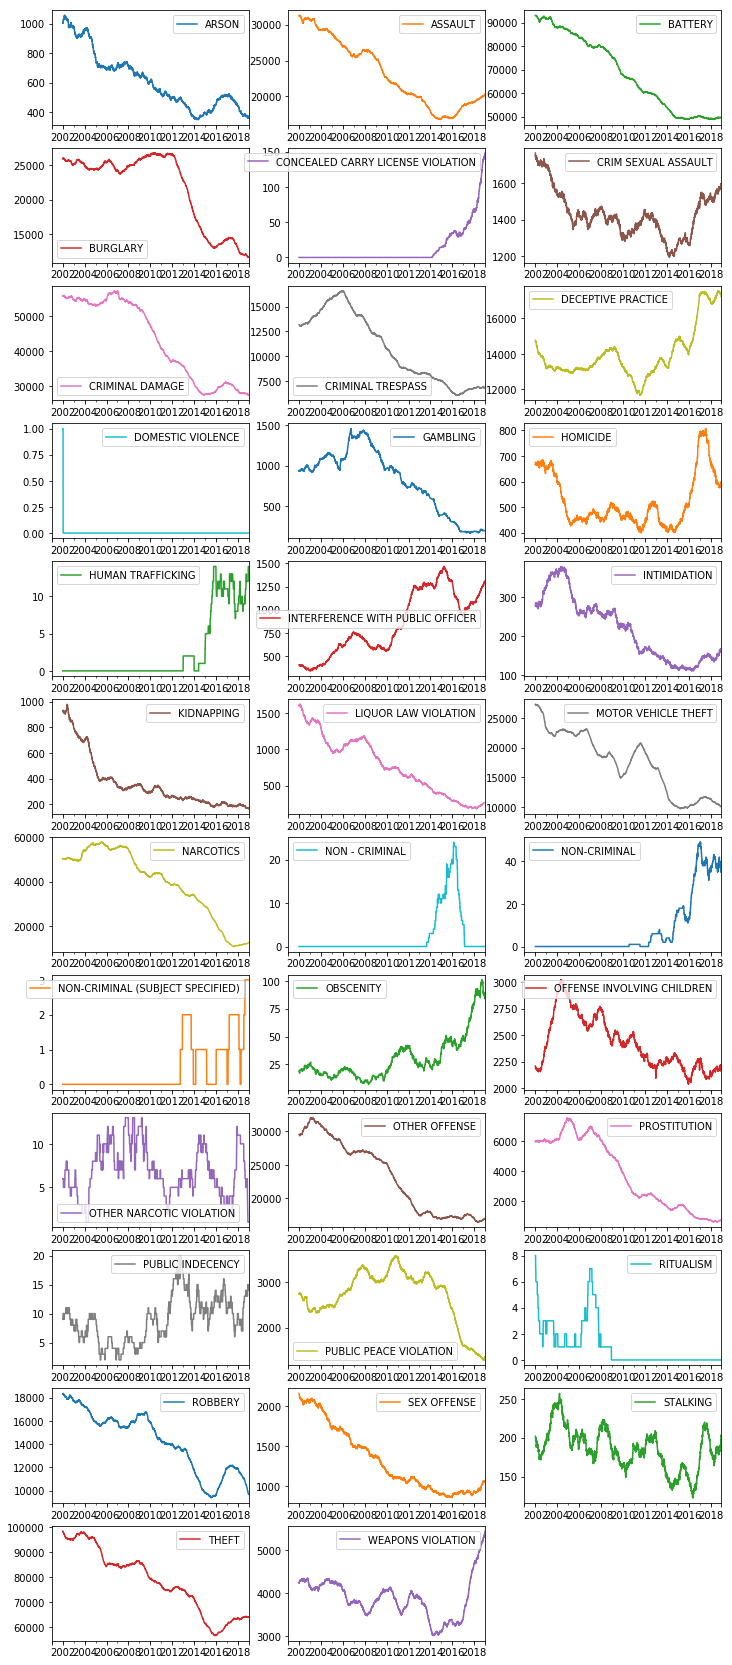

In [102]:
crimes_per_district.index = pd.DatetimeIndex(crimes_per_district.index)
plo = crimes_per_district.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

In [106]:
topk_loc_descr = chicago_cmr1.groupby(['Primary Type', 'Location Description']).size().reset_index(name='counts').groupby('Primary Type').apply(lambda x: x.sort_values('counts',ascending=False).head(3))

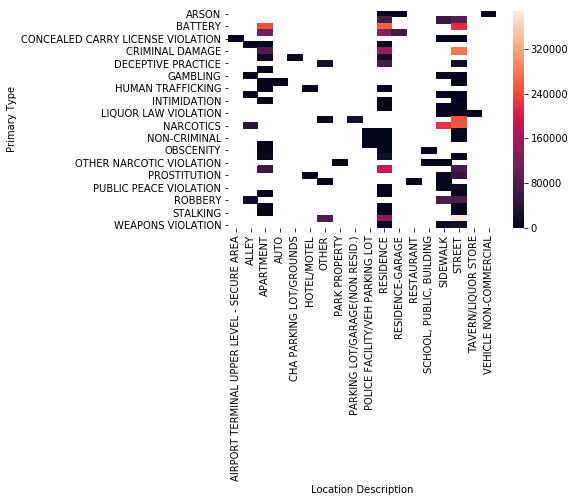

In [107]:
pivotdf = topk_loc_descr.pivot(index='Primary Type', columns='Location Description', values='counts')
sns.heatmap(pivotdf)

In [ ]:
chicago_cmr1